In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from torch_lr_finder import LRFinder


c:\Users\Shanto\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device= 'cuda'

In [3]:
# Assuming you've already loaded the data:
df = pd.read_excel('Temparature_Mymensingh.xlsx')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# # Cyclical transformations
# df['Day_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
# df['Day_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)

# df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
# df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

In [4]:
# Updated features
features = ['DayOfYear','Month','Year','Temp']
target = ['Temp']

### Scaling

In [5]:
# Scale your features
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_scaled = scaler_x.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[target])

### Sequencing data

In [6]:
def sequence(x, y, length):
    xs, ys = [], []
    for i in range(len(x) - length):
        xs.append(x[i:i + length])
        ys.append(y[i + length])
    return np.array(xs), np.array(ys)

sequence_length = 25 
X, y = sequence(x_scaled, y_scaled, sequence_length)


### Spliting data

In [7]:
# torch.manual_seed(42)
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.20, shuffle=False)

# now converting to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
len(X_train),len(X_test)

(7577, 1895)

### Using DataLoader

In [8]:
# from torch.utils.data import DataLoader, TensorDataset

# batch_size=32

# train_data= TensorDataset(X_train,y_train)
# test_data= TensorDataset(X_test,y_test)

# train_data_loader=DataLoader(batch_size=batch_size,
#                              shuffle=False,
#                              dataset=train_data)

# test_data_loader=DataLoader(batch_size=batch_size,
#                             shuffle=False,
#                             dataset=test_data)

### Making the model

In [9]:
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                            batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        # self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        # self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)
        # self.relu3=nn.ReLU()
        # self.dropout3=nn.Dropout(.5)
        # self.fc4=nn.Linear(32,1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.relu(self.fc1(out))
        out = self.relu2(self.fc2(out))
        # out = self.dropout3(self.relu3(self.fc3(out)))
        out = self.fc3(out)
        return out

### Tuning the HyperParameters and Best LR

In [31]:
# Define your hyperparameter ranges
n_splits_list = [5]                   # Add/adjust values as you want
batch_sizes = [32]
hidden_sizes = [128, 256, 512]
num_layers_list = [2, 3, 5]
learning_rates = [1e-4, 1e-5]

input_size = X_train.shape[2]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_loss = float('inf')
best_params = None

X_np = X_train.numpy()
y_np = y_train.numpy()

for n_splits in n_splits_list:
    print(f"\nTesting n_splits={n_splits}")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for batch_size in batch_sizes:
        for hidden_size in hidden_sizes:
            for num_layers in num_layers_list:
                for lr in learning_rates:
                    fold_losses = []
                    for train_idx, val_idx in kf.split(X_np):
                        X_tr = torch.tensor(X_np[train_idx], dtype=torch.float32)
                        y_tr = torch.tensor(y_np[train_idx], dtype=torch.float32)
                        X_val = torch.tensor(X_np[val_idx], dtype=torch.float32)
                        y_val = torch.tensor(y_np[val_idx], dtype=torch.float32)

                        train_ds = TensorDataset(X_tr, y_tr)
                        val_ds = TensorDataset(X_val, y_val)
                        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
                        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

                        model = ImprovedLSTM(input_size, hidden_size, num_layers).to(device)
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                        criterion = nn.MSELoss()

                        for epoch in range(10):  # You can increase epochs for better accuracy
                            model.train()
                            for xb, yb in train_loader:
                                xb, yb = xb.to(device), yb.to(device)
                                optimizer.zero_grad()
                                out = model(xb)
                                loss = criterion(out, yb)
                                loss.backward()
                                optimizer.step()

                        model.eval()
                        val_losses = []
                        with torch.no_grad():
                            for xb, yb in val_loader:
                                xb, yb = xb.to(device), yb.to(device)
                                out = model(xb)
                                loss = criterion(out, yb)
                                val_losses.append(loss.item())
                        fold_losses.append(np.mean(val_losses))

                    avg_loss = np.mean(fold_losses)
                    print(f"n_splits={n_splits} | Batch={batch_size} | Hidden={hidden_size} | Layers={num_layers} | LR={lr} | Val Loss={avg_loss:.4f}")
                    if avg_loss < best_loss:
                        best_loss = avg_loss
                        best_params = (n_splits, batch_size, hidden_size, num_layers, lr)

print("\nBest Params:")
print(f"n_splits={best_params[0]}, Batch={best_params[1]}, Hidden={best_params[2]}, Layers={best_params[3]}, LR={best_params[4]}, Val Loss={best_loss:.4f}")


Testing n_splits=5
n_splits=5 | Batch=32 | Hidden=128 | Layers=2 | LR=0.0001 | Val Loss=0.0047
n_splits=5 | Batch=32 | Hidden=128 | Layers=2 | LR=1e-05 | Val Loss=0.0082
n_splits=5 | Batch=32 | Hidden=128 | Layers=3 | LR=0.0001 | Val Loss=0.0051
n_splits=5 | Batch=32 | Hidden=128 | Layers=3 | LR=1e-05 | Val Loss=0.0068
n_splits=5 | Batch=32 | Hidden=128 | Layers=5 | LR=0.0001 | Val Loss=0.0051
n_splits=5 | Batch=32 | Hidden=128 | Layers=5 | LR=1e-05 | Val Loss=0.0065
n_splits=5 | Batch=32 | Hidden=256 | Layers=2 | LR=0.0001 | Val Loss=0.0048
n_splits=5 | Batch=32 | Hidden=256 | Layers=2 | LR=1e-05 | Val Loss=0.0054
n_splits=5 | Batch=32 | Hidden=256 | Layers=3 | LR=0.0001 | Val Loss=0.0049
n_splits=5 | Batch=32 | Hidden=256 | Layers=3 | LR=1e-05 | Val Loss=0.0056
n_splits=5 | Batch=32 | Hidden=256 | Layers=5 | LR=0.0001 | Val Loss=0.0054
n_splits=5 | Batch=32 | Hidden=256 | Layers=5 | LR=1e-05 | Val Loss=0.0058
n_splits=5 | Batch=32 | Hidden=512 | Layers=2 | LR=0.0001 | Val Loss=0.005

In [32]:
# [SET BEST PARAMS]
batch_size = best_params[1]
hidden_size = best_params[2]

In [33]:
# [DATALOADER - USE BEST BATCH SIZE]
from torch.utils.data import DataLoader, TensorDataset
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_data_loader = DataLoader(batch_size=batch_size, shuffle=False, dataset=train_data)
test_data_loader = DataLoader(batch_size=batch_size, shuffle=False, dataset=test_data)


In [34]:
# model , loss , optimizer
torch.manual_seed(42)
model_0 = torch.compile(ImprovedLSTM(input_size=4, hidden_size=hidden_size,num_layers=best_params[3]).to(device))
loss_fn= nn.MSELoss()
optimizer=torch.optim.Adam(model_0.parameters(), lr=best_params[4])

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)

In [35]:
# Training
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    #train
    model.train()
    train_loss=0
    for batch, (X,y) in enumerate(data_loader):
        X,y=X.to(device),y.to(device)
        y_pred=model(X)
        loss=loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss +=loss
    # train_loss /=len(data_loader)
    print (f'Train loss: {train_loss: .3f}')
    return train_loss


In [36]:
# Testing
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
    
    model.eval()
    test_loss=0
    with torch.inference_mode():
        for X,y in data_loader:
            X,y=X.to(device),y.to(device)

            test_pred=model(X)
            loss=loss_fn(test_pred,y)

            test_loss +=loss
        # test_loss /= len(data_loader)
    print(f'Test Loss: {test_loss: .3f}')
    return test_loss

### Early Stopping

In [37]:
class EarlyStoppingByLoss:
    def __init__(self, patience:int, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_epoch = -1  # Track the epoch of the best model

    def __call__(self, test_loss, model, epoch):
        if test_loss < self.best_loss:
            self.best_loss = test_loss
            self.counter = 0
            self.best_epoch = epoch
            torch.save(model.state_dict(), 'checkpoint.pt')
            if self.verbose:
                print(f"New best test loss: {test_loss:.4f} at epoch {epoch+1}. Saving model.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in test loss for {self.counter} epoch(s).")
            if self.counter >= self.patience:
                if self.verbose:
                    print(f"Early stopping: No improvement in test loss for {self.patience} epochs.")
                self.early_stop = True

In [38]:
# Training testing data
from tqdm.auto import tqdm

epochs=5000

train_losses = []
test_losses = []
early_stopping=EarlyStoppingByLoss(patience=30,verbose=True)
for epoch in tqdm(range(epochs)):
    print(f'\nEpoch: {epoch}\n------')

    train_loss=train_step(model=model_0,
                          data_loader=train_data_loader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          device=device)
    test_loss=test_step(model=model_0,
                        data_loader=test_data_loader,
                        loss_fn=loss_fn,
                        device=device)

    # scheduler.step(test_loss) 

    if torch.is_tensor(train_loss):
        train_loss = train_loss.cpu().item()
    if torch.is_tensor(test_loss):
        test_loss = test_loss.cpu().item()
    train_losses.append(train_loss)
    test_losses.append(test_loss)

     # Early stopping step
    early_stopping(test_loss, model_0, epoch)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

best_epoch = early_stopping.best_epoch
print(f"Best model saved at epoch {best_epoch+1}")

# Restore best model
model_0.load_state_dict(torch.load('checkpoint.pt'))

  0%|          | 0/5000 [00:00<?, ?it/s]


Epoch: 0
------
Train loss:  32.514
Test Loss:  1.569
New best test loss: 1.5688 at epoch 1. Saving model.

Epoch: 1
------
Train loss:  4.073
Test Loss:  0.318
New best test loss: 0.3183 at epoch 2. Saving model.

Epoch: 2
------
Train loss:  1.323
Test Loss:  0.316
New best test loss: 0.3156 at epoch 3. Saving model.

Epoch: 3
------
Train loss:  1.281
Test Loss:  0.311
New best test loss: 0.3107 at epoch 4. Saving model.

Epoch: 4
------
Train loss:  1.253
Test Loss:  0.313
No improvement in test loss for 1 epoch(s).

Epoch: 5
------
Train loss:  1.245
Test Loss:  0.313
No improvement in test loss for 2 epoch(s).

Epoch: 6
------
Train loss:  1.247
Test Loss:  0.320
No improvement in test loss for 3 epoch(s).

Epoch: 7
------
Train loss:  1.236
Test Loss:  0.317
No improvement in test loss for 4 epoch(s).

Epoch: 8
------
Train loss:  1.231
Test Loss:  0.337
No improvement in test loss for 5 epoch(s).

Epoch: 9
------
Train loss:  1.238
Test Loss:  0.351
No improvement in test loss

<All keys matched successfully>

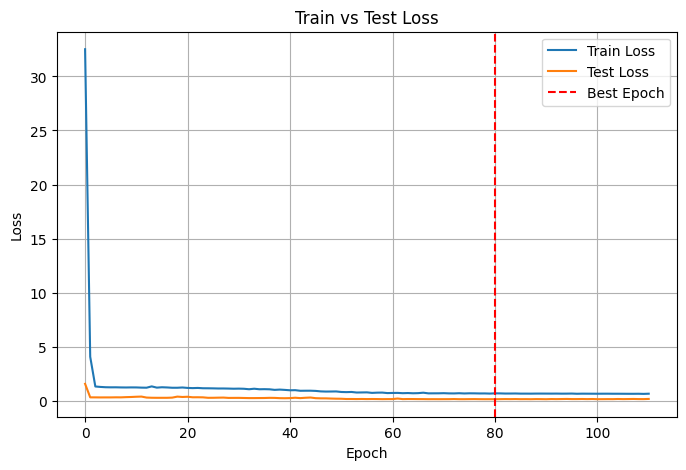

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)
plt.show()

### Result Library

In [40]:
# Get the result library
import tqdm
from tqdm.auto import tqdm
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
            #    accuracy_fn,
               device:torch.device=device,
               best_epoch=None):
    """Returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc=0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
           X,y=X.to(device),y.to(device)
           y_pred = model(X)
           loss +=loss_fn(y_pred,y)
        # loss /=len(data_loader)
    
    result = {'model_name':model.__class__.__name__,
              'test_loss': loss.item(),
              }
    if best_epoch is not None:
        result['best_epoch'] = best_epoch+1
    return result

In [41]:
model_0.load_state_dict(torch.load('checkpoint.pt'))
result = eval_model(model_0, 
                    test_data_loader, 
                    loss_fn, 
                    device, 
                    best_epoch)
print(result)

  0%|          | 0/60 [00:00<?, ?it/s]

{'model_name': 'OptimizedModule', 'test_loss': 0.1445959359407425, 'best_epoch': 81}


### Making Prediction

In [42]:
# making prediction
from tqdm.auto import tqdm
model_0.load_state_dict(torch.load('checkpoint.pt'))
y_preds=[]
y_targets=[]
model_0.eval()

with torch.inference_mode():
    for X,y in tqdm(test_data_loader, desc="Making predictions....."):
        X,y= X.to(device), y.to(device)
        y_pred=model_0(X).cpu().numpy()
        y_preds.append(y_pred)
        y_targets.append(y.cpu().numpy())

y_preds= np.vstack(y_preds)
y_targets=np.vstack(y_targets)

Making predictions.....:   0%|          | 0/60 [00:00<?, ?it/s]

### Inverse scaling.

* It is important to reform your main data into original scale. because here is scaled the main data before training

In [43]:
predicted=scaler_y.inverse_transform(y_preds)
actual=scaler_y.inverse_transform(y_targets)

In [44]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
R2=r2_score(actual,predicted)
CoD= root_mean_squared_error(actual,predicted)
print(f"RMSE is: {CoD} | R² is: {R2}")

RMSE is: 1.1796470880508423 | R² is: 0.928662121295929


### Visualize

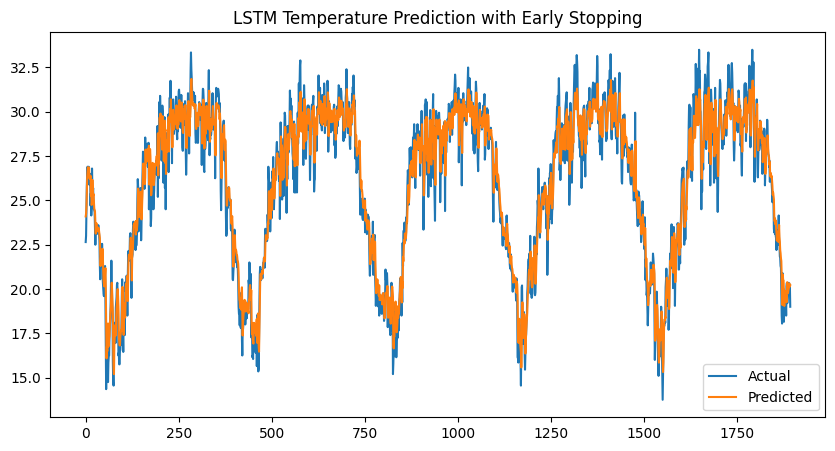

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.title('LSTM Temperature Prediction with Early Stopping')
plt.show()

# Forecasting

In [46]:
# Create future dates from 2025-01-01 to 2034-06-06
start="2025-01-01"
end="2028-12-31"
future_dates = pd.date_range(start=start, end=end, freq="D")

future_df = pd.DataFrame({'Date': future_dates})
future_df['DayOfYear'] = future_df['Date'].dt.dayofyear
future_df['Month'] = future_df['Date'].dt.month
future_df['Year'] = future_df['Date'].dt.year


In [47]:
# Prepare the last 60 rows as the seed sequence

last_60_scaled = x_scaled[-sequence_length:]  # already scaled features up to 2024-12-31
last_60_scaled = torch.tensor(last_60_scaled, dtype=torch.float32).unsqueeze(0).to(device)


In [48]:
# Forecasting
import numpy as np

import numpy as np

model_0.eval()
predictions_scaled = []

# Start with the last known sequence (scaled), shape: [1, seq_len, 4]
current_sequence = last_60_scaled.clone()  

x_min = scaler_x.data_min_    # array of length 4
x_max = scaler_x.data_max_

for idx, row in future_df.iterrows():
    day = row['DayOfYear']
    month = row['Month']
    year = row['Year']

    # Get the last known temperature (scaled)
    if len(predictions_scaled) == 0:
        last_temp_scaled = current_sequence[0, -1, 3].item()   # index 3 for Temp
    else:
        last_temp_scaled = predictions_scaled[-1]

    # Scale all features as during training
    day_scaled = (day - x_min[0]) / (x_max[0] - x_min[0])
    month_scaled = (month - x_min[1]) / (x_max[1] - x_min[1])
    year_scaled = (year - x_min[2]) / (x_max[2] - x_min[2])

    new_feature_scaled = [
        day_scaled,
        month_scaled,
        year_scaled,
        last_temp_scaled
    ]

    nf = torch.tensor(new_feature_scaled, dtype=torch.float32).unsqueeze(0).to(device)  # [1,4]
    current_sequence = torch.cat(
        [current_sequence[:, 1:, :], nf.unsqueeze(1)],
        dim=1
    )

    with torch.inference_mode():
        next_pred = model_0(current_sequence)

    predictions_scaled.append(next_pred.cpu().item())


In [49]:
#  Inverse transform predictions

predictions_scaled = np.array(predictions_scaled).reshape(-1, 1)
predictions = scaler_y.inverse_transform(predictions_scaled)

# Add predictions to the future_df
future_df['PredictedTemp'] = predictions


In [50]:
# Step 5: Extract and print forecasted value for 6 June 2034
specific_date = "2025-8-5"
forecast_value = future_df.loc[future_df["Date"] == specific_date, "PredictedTemp"].values[0]
print(f"Forecasted temperature on {specific_date}: {forecast_value:.2f} °C")


Forecasted temperature on 2025-8-5: 29.79 °C


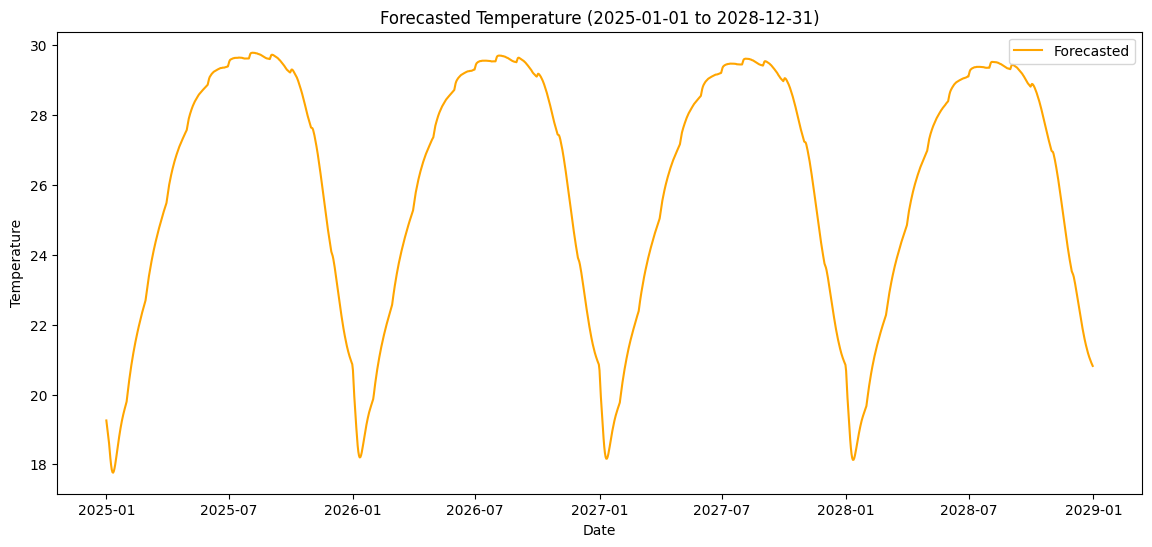

In [51]:
#  Plot future forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(future_df['Date'], future_df['PredictedTemp'], label='Forecasted', color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title(f'Forecasted Temperature ({start} to {end})')
plt.legend()
plt.show()
